# Cardiovascular heart disease: Feature Engineering, tuning and Comparison of Different Machine Learning Algorithms



The goal of this project is to predict whether an individual suffers from cardiovascular heart disease using some predictors and to find the main risk factors for a cardiovascular heart disease. This information helps to improve preventive medical checkups and to react quicker in emergencies.


---


**Goal:**
Predict whether a patient should be diagnosed with Heart Disease.
 - **1** = patient diagnosed with Heart Disease 
 - **0** = patient not diagnosed with Heart Disease


 --- 

 ### Contents

1. [Setup](#setup)
1. [Data Preprocessing and Analysis](#bir)
   1. [Outlier detection - ap_hi, ap_lo](#outlierdetection)
   1. [IQR based filtering - height, weight](#iqr)
   1. [BMI - filtering](#bmi)
1. [Feature Engineering](#feature)
1. [Machine Learning Models](#mlmodels)
    1. [Model preparation](#modelprep)
    1. [Logistic Regression](#logreg)
        1. [Feature Subset Selection](#logreg2)
        1. [Tuned Logistic regression](#logreg3)
    1. [Linear Discriminant analysis](#lda)
    1. [Decision Tree](#dt)
        1. [Tuned Decision Tree](#dt2)
    1. [Gradient Boosting Classifier](#gbc)
    1. [K Nearest Neighbors](#knn)
        1. [Feature Subset Selection](#knn2)
        1. [Hyperparameter Tuning](#knn3)
    1. [Quadratic Discriminant Analysis](#qda)
        1. [No Subset Selection](#qda1)
        1. [With Forward Subset Selection](#qda2)
    1. [Random Forest](#rf)
    1. [Support Vector Classifier](#svc)
1. [Comparison and Conclusion](#conc)








## How to use this notebook
<div class="alert alert-block alert-info">

Some methods used in this notebook for tuning and evaluating the classifiers take significantly more time than the runtime limit of 30 minutes. To stay within this 30 minute constraint the results of these methods were used without actually executing the methods providing them. 
This is implemented through a "**viewer mode**". The results for the conclusion do not change if viewer mode is enabled but they are not calculated again from scratch. 

<font>NOTE:</font> Please keep all viewer_mode variables set to True unless you intent to wait up to ~30 minutes to verify a certain result.
- viewer_mode = **True** : short runtime with all the results
- viewer_mode = **False** : very long runtime with all results newly calculated
</div>

# 0 - Setup <a class="anchor"  id="setup"></a>


Importing all the required libraries and functions

In [2]:
### Data Handline
import pandas as pd
import numpy as np

### Utility
import math
import warnings
import string

### Plotting
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D


# Model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Scikit-learn
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, ConfusionMatrixDisplay # plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold


#LDA
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import SequentialFeatureSelector

#RND Forest
from sklearn.ensemble import RandomForestClassifier

# K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

#Support Vector Classifier
from sklearn import svm
from sklearn.svm import LinearSVC

# Seaborn
import seaborn as sns

# warnings.filterwarnings("ignore")

**Reading in the raw data set.**

In [3]:
cardio = pd.read_csv("./cardio_train.csv",delimiter=";")

cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


The published dataset  (**cardio_train.csv**) has 12 features meaning and types can be listed as follows :


| Column | Description |
| ------ | ----------- |
| age | Age (int)|
| height | Height (int) |
| weight | Weight (float) |
| gender | Gender (categorical code )|
| ap_hi | Systolic blood pressure (int) |
| ap_lo | Diastolic blood pressure (int) |
| cholesterol | Cholesterol (1:normal, 2: above normal, 3: well above normal) |
| gluc | Glucose (1:normal, 2: above normal, 3: well above normal) |
| smoke | Smoking (binary) |
| alco | Alcohol intake (binary) |
| active | Physical activity (binary) |
| cardio | Presence or absence of cardiovascular disease (binary) |


---


Our data has three types of data: **Quantitative data**, **Categorical data** and **Binary data**

In [14]:
cardio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Comment: *On the first sight there are no data type problems.*

# 1 - Data Preprocessing and Exploratory Data Analysis <a class="anchor"  id="bir"></a>

**More analyse for data quality problems such as unrealistic values..etc**


In [4]:
num_entries = cardio.shape[0]*cardio.shape[1]
print('Number of entries in the dataframe: ', num_entries)

num_missing_values = cardio.isna().sum().sum()
print('Missing values: ', num_missing_values, '\n')

cardio_dup = cardio.duplicated().sum()
if cardio_dup:
    print('Duplicates Rows in Dataset are : {}'.format(cardio_dup))
else:
    print('Dataset contains no Duplicate Values')

Number of entries in the dataframe:  910000
Missing values:  0 

Dataset contains no Duplicate Values


In [5]:
#Dropping all duplicated rows.
cardio.drop_duplicates(inplace=True)

#dropping id column because it is clearly not correlated in any way with the target
cardio.drop(['id'], axis=1, inplace=True)

In [6]:
cardio.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


**Observations**
- 'Age' column has to be recalculated it has a minimum values of 10789' which is unrealistic therefore they represents a missing/incorrect value.
- 'Weight' column have unrealistic min/max values.
- Systolic blood pressure "ap_hi" and Diastolic blood pressure "ap_lo" cannot be negative
- If ap_hi and ap_lo are more than 180 and 120 mmHg respectively then it is an hypertensive crisis, which is an emergency case. Therefore max values are not realistic.



In [7]:
#Age is written in days, so we're converting it to years 
cardio['age'] = cardio['age'].apply(lambda x: x/365)  

## 1.1 - Outlier detection - ap_hi, ap_lo <a class="anchor"  id="outlierdetection"></a>

According the figure below we can assume values larger than *280* mm Hg and *120* mm Hg for ap_hi and ap_lo respectively will be dropped as outliers. As well as negative values because they can not be negative.

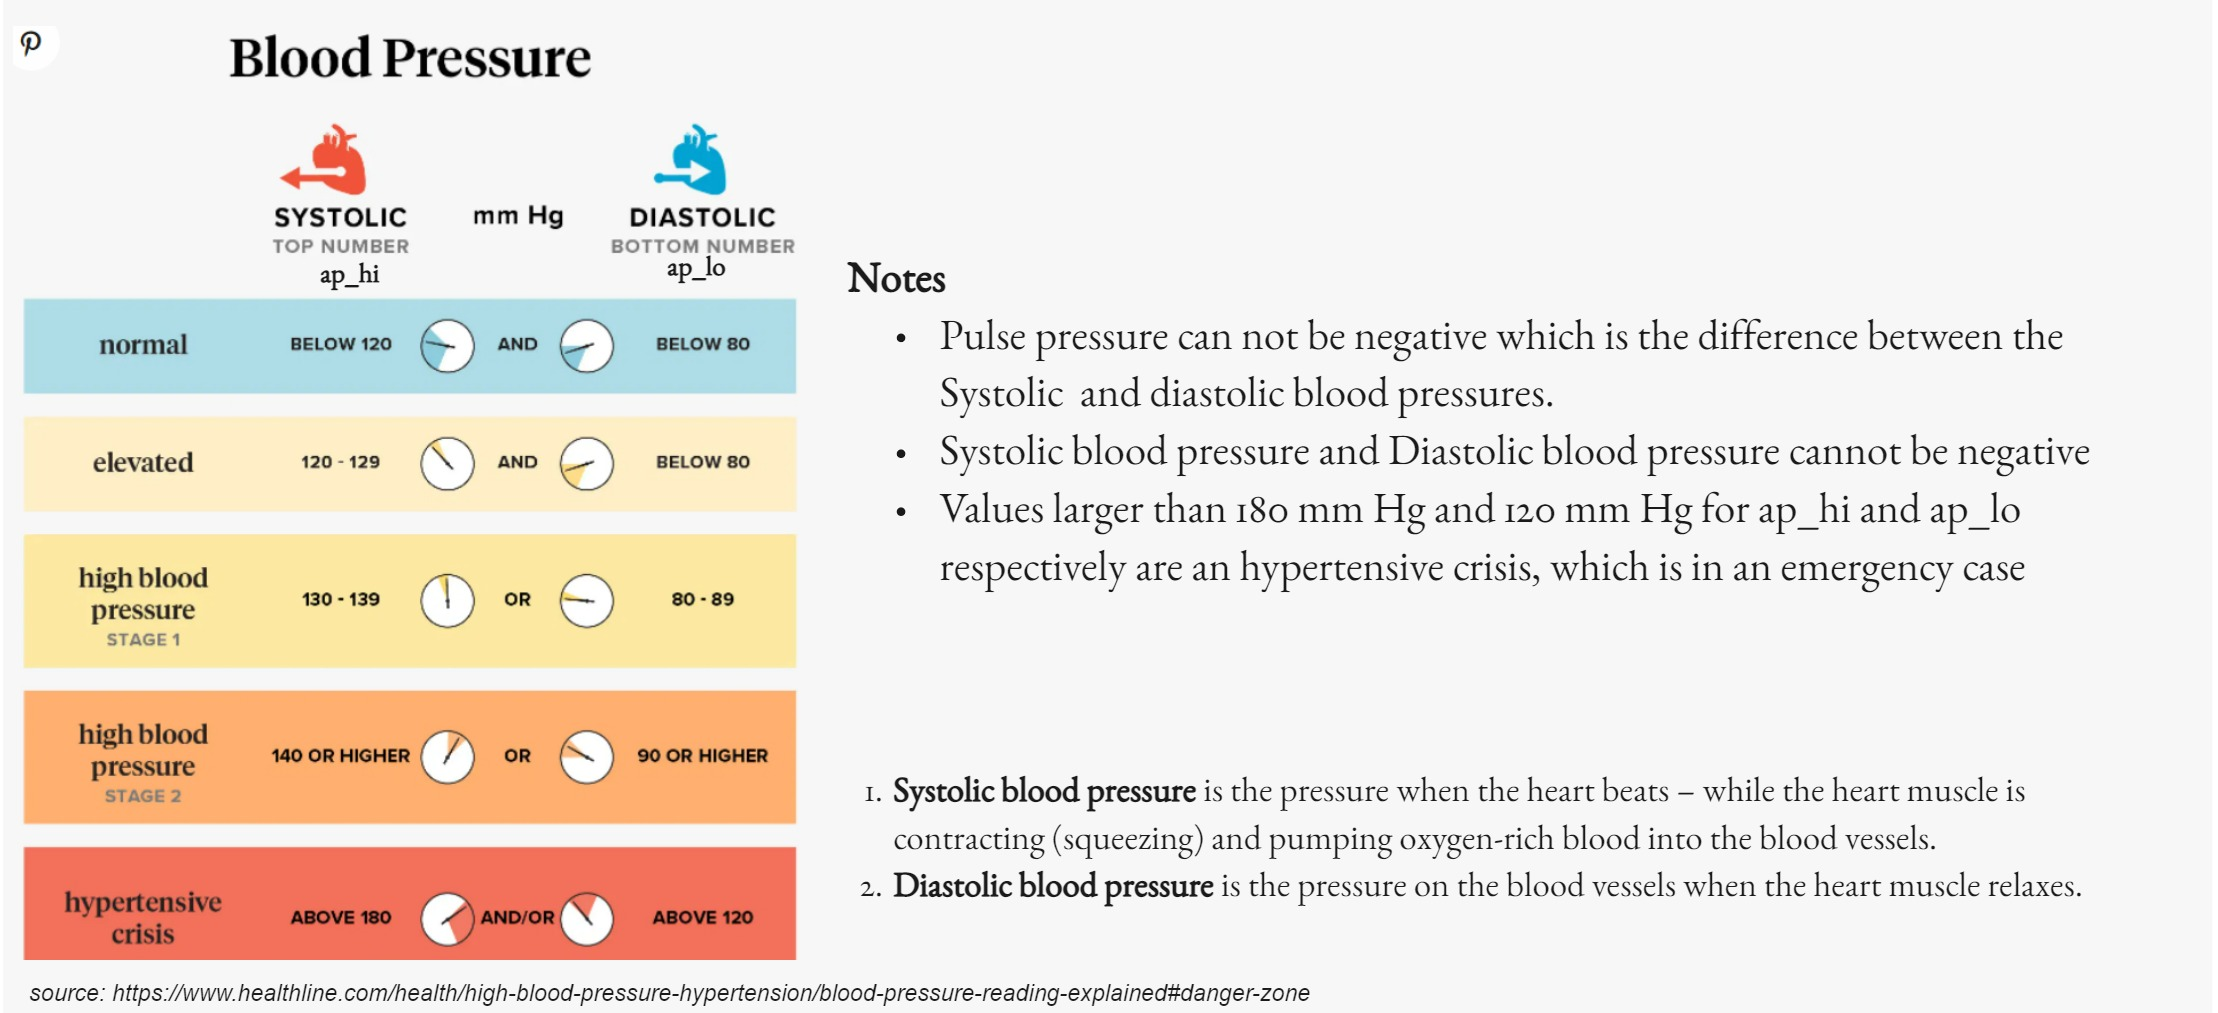

In [8]:
outliers = len(cardio[(cardio["ap_hi"]>=280) | (cardio["ap_lo"]>=220) | (cardio["ap_lo"] < 0) | (cardio["ap_hi"] < 0) | (cardio["ap_hi"]<cardio["ap_lo"])])

print(f'we have total {outliers} outliers')
print(f'percent missing: {round(outliers/len(cardio)*100,1)}%')

we have total 1275 outliers
percent missing: 1.8%


In [9]:
#Filtering out the unrealistic data of Systolic blood pressure and Diastolic blood pressure
cardio = cardio[ (cardio['ap_lo'] >= 0) & (cardio['ap_hi'] >= 0) ]  #remove negative values
cardio = cardio[ (cardio['ap_lo'] <= 220) & (cardio['ap_hi'] <= 280) ]  #remove fishy data points
cardio = cardio[ (cardio['ap_lo'] < cardio['ap_hi']) ]  #remove systolic higher than diastolic


In [10]:
Q1_hi = cardio['ap_hi'].quantile(0.05) # 5th percentile of the data of the given feature
Q3_hi = cardio['ap_hi'].quantile(0.95)  # 95th percentile of the data of the given feature
IQR_hi = Q3_hi - Q1_hi
lower, upper = Q1_hi - 1.5 * IQR_hi, Q3_hi + 1.5 * IQR_hi
cardio = cardio[(cardio['ap_hi'] >= lower) & (cardio['ap_hi'] <= upper)]  

Q1_lo = cardio['ap_lo'].quantile(0.05) # 5th percentile of the data of the given feature
Q3_lo = cardio['ap_lo'].quantile(0.95)  # 95th percentile of the data of the given feature
IQR_lo = Q3_lo - Q1_lo
lower, upper = Q1_lo - 1.5 * IQR_lo, Q3_lo + 1.5 * IQR_lo
cardio = cardio[(cardio['ap_lo'] >= lower) & (cardio['ap_lo'] <= upper)]  

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


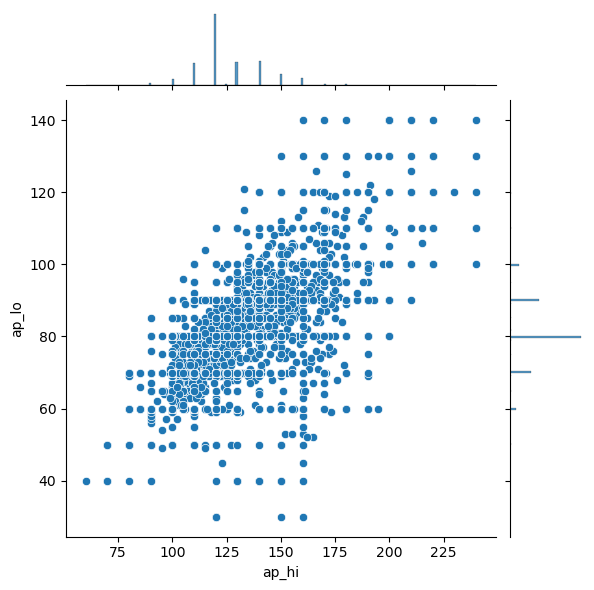

In [11]:
sns.jointplot(x='ap_hi', y='ap_lo', data=cardio);

## 1.2 - IQR based filtering - height, weight <a class="anchor"  id="iqr"></a>

Good for skewed data distributions. We can observe lot's of outliers (points below lower fence and above upper fence)





<Axes: >

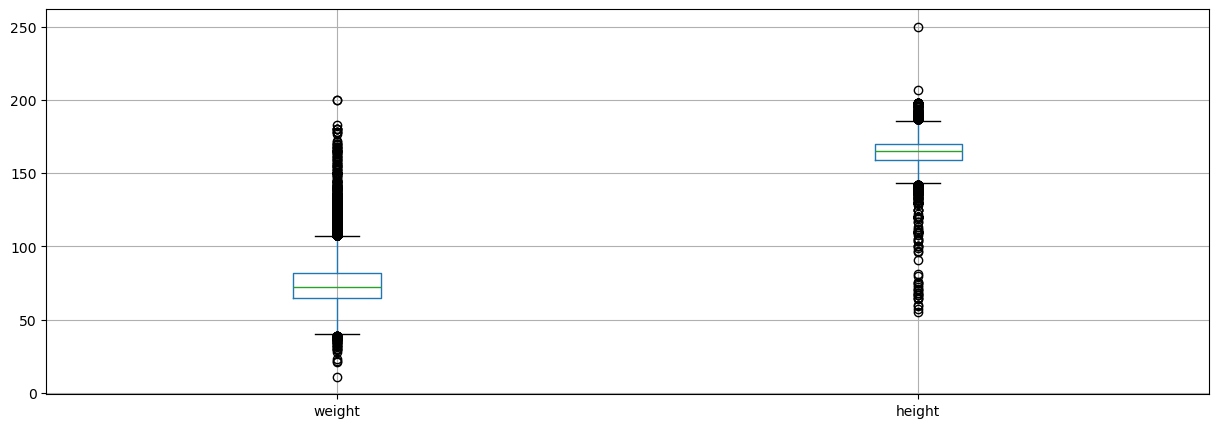

In [12]:
plt.figure(figsize=(15,5))
cardio.boxplot(['weight','height'])

In [13]:
#--------------------1.Variant-----------------------------------------------
#Filtering out the smallest and tallest human ever known were 54 cm and 251 cm respectively so 
len(cardio[(cardio['height'] > 251) | (cardio['height'] < 54)])

0

In [25]:
#-------------------2.Variant------------------------------------------------
#Function that detects the outlier given interquartile range
def detect_outliers(df,q1,q3):
  for col in df.columns:
    df_feature = df[col]
    Q1 = df_feature.quantile(q1) # 25th percentile of the data of the given feature
    Q3 = df_feature.quantile(q3)  # 75th percentile of the data of the given feature
    IQR = Q3 - Q1    #IQR is interquartile range. 
    print(f'Feature: {col}-------------')
    print(f'Percentiles: {int(q1*100)}th={Q1}, {int(q3*100)}th={Q3}, IQR={IQR}')
    # calculate the outlier lower and upper bound
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    # identify outliers
    outliers = [x for x in df_feature if x < lower or x > upper]
    print('Identified outliers: %d \n' % len(outliers))
    # remove outliers 
    #cardio = df[(df_feature >= lower) & (df_feature <= upper)]  
  
detect_outliers(cardio[['height', 'weight']],0.05,0.95)

Feature: height-------------
Percentiles: 5th=152.0, 95th=178.0, IQR=26.0
Identified outliers: 46 

Feature: weight-------------
Percentiles: 5th=55.0, 95th=100.0, IQR=45.0
Identified outliers: 20 



In [26]:
#After the observation we can remove the outliers weight, height
cardio_cleaned = cardio 
for col in ['height','weight']:
  Q1 = cardio[col].quantile(0.05) # 5th percentile of the data of the given feature
  Q3 = cardio[col].quantile(0.95)  # 95th percentile of the data of the given feature
  IQR = Q3 - Q1
  lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
  cardio_cleaned = cardio_cleaned[(cardio_cleaned[col] >= lower) & (cardio_cleaned[col] <= upper)]  


## 1.3 - BMI - filtering <a class="anchor"  id="bmi"></a>

we can create new feature BMI (Body Mass Index) with height and weight. It might lead us to get better insights. The BMI says whether the person is in normal health or not . To calcualte it we have a formula

\begin{equation}
BMI = \tfrac{weight}{height^2}
\end{equation}

*BMI = kg/m2 where kg is a person's weight in kilograms and m2 is their height in metres squared*

In [27]:
# calculating the patient BMI (Body Mass Index)  
cardio_cleaned['BMI'] = round(cardio_cleaned['weight']/((cardio_cleaned['height']/100)**2),1)
cardio_cleaned.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0,22.0
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1,34.9
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1,23.5
3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1,28.7
4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0,23.0


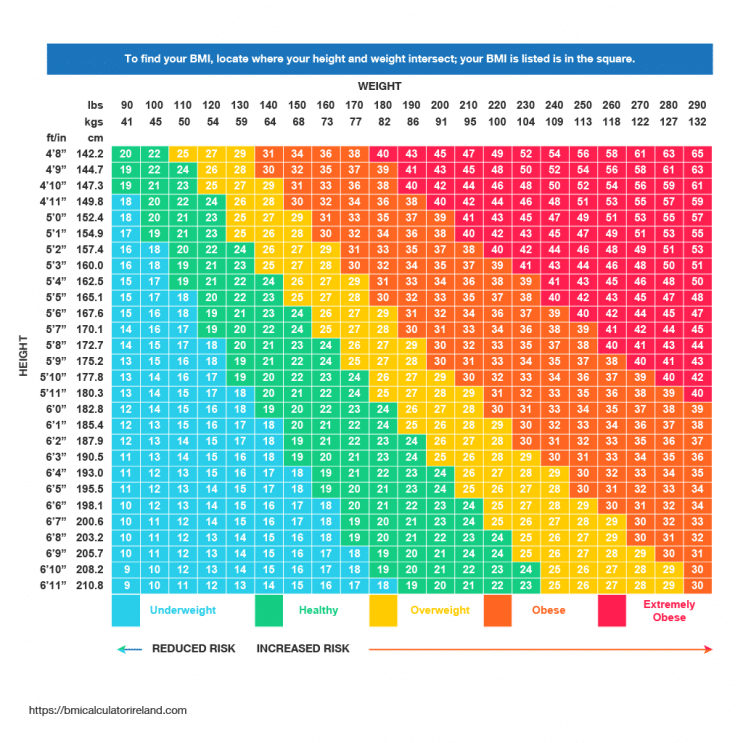

- As you can see from the chart above, BMI values of 60+ refer to extreme obesity and 9- refers to underweight, which is an increased risk for poor health.

In [28]:
#Filtering out the extreme values (unhealthy health) of BMI data according to BMI chart above
cardio_cleaned = cardio_cleaned[ (cardio_cleaned['BMI'] < 60) & (cardio_cleaned['BMI'] > 10)]

In [29]:
#Dataset after cleaning
print(f'Number of rows of cardio dataset after data preprocessing: {len(cardio_cleaned)}')
print(f'How much percent missing: {round((70000-len(cardio_cleaned))/70000*100,2)}%')

Number of rows of cardio dataset after data preprocessing: 68584
How much percent missing: 2.02%


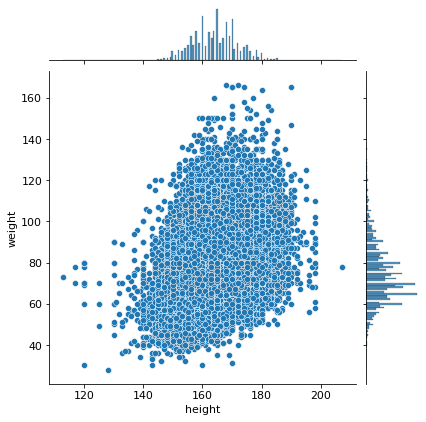

In [30]:
#To study the joint distribution of two numerical features, the jointplot of the Seaborn library can be useful:
sns.jointplot(x='height', y='weight', data=cardio_cleaned);

[Text(0, 0, 'Male'), Text(1, 0, 'Female')]

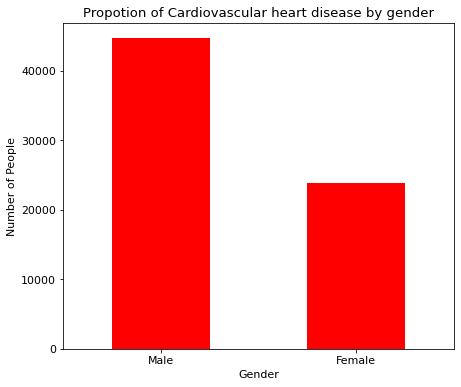

In [31]:
#Distribution of cardiovascular heart disease by gender
gender = cardio_cleaned['gender'].value_counts()
plt.figure(figsize=(7, 6))
ax = gender.plot(kind='bar', rot=0, color="r")
ax.set_title("Propotion of Cardiovascular heart disease by gender", y = 1)
ax.set_xlabel('Gender')
ax.set_ylabel('Number of People')
ax.set_xticklabels(('Male', 'Female'))

- From the bar chart, it can be seen that the probability of disease is higher when the gender is male.

# 2 - Feature Engineering <a class="anchor"  id="feature"></a>

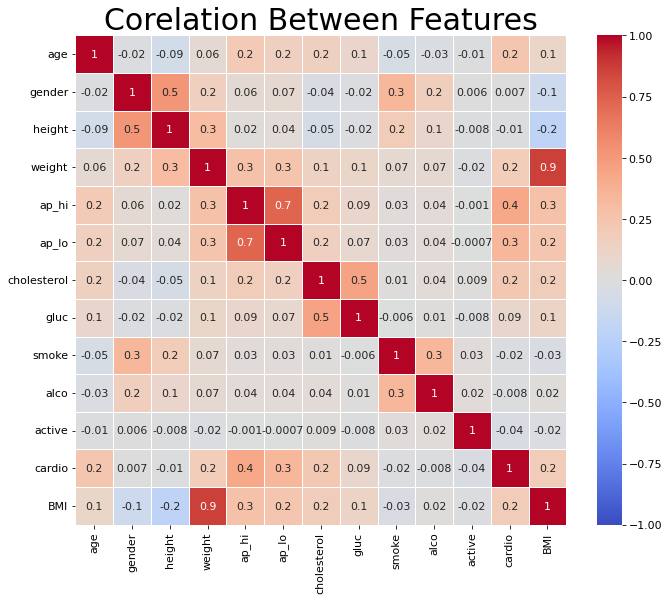

In [32]:
#plotting correlation map
plt.rcParams.update({'font.size': 11})
fig, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(cardio_cleaned.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=ax, fmt='.1g', linewidths=.5);
plt.title('Corelation Between Features', fontsize = 30)
plt.show()

The heatmap above in gives the basis for understanding how the health factors in the dataset are correlated with one another. High correlation within independent features means both represent same information. So when we drop one of the feature we won't lose much quality data

As a patient’s age increases, their resting blood pressure tends to increase and their maximum heart rate achieved tends to decrease. The correlation between age and cardio is positive, however it is not a very strong correlation with a value of 0.2. further observations can be found below.

**Observations**
*   age and cholesterol have significant impact, but not very high correlated with target class.
*   ap_hi has the highest correlation with the target value, so it has significant impact to our model. also same with ap_lo
*   Newly formed feature 'BMI' doesn't have good correlation with the target and it highly correlated with "weight" so one could drop one of the features.
*   'gender', 'smoke' and 'height' are the least correlated features with target




# 3- ML models <a class="anchor"  id="mlmodels"></a>

Here, we're using different Machine Learning (ML) algortihms to predict the existence of cardiovascular diseases in patients according to our dataset. We're using multiple algorithms and comparing them to each other according to their results.


- Logistic Regression
- LDA
- Decision Tree
- Gradient Boosting CLassifier
- K-Nearest Neighbour
- QDA
- Random Forest
- SVM


**Hyperparatemer Tuning**
Our aim to get a good result therefore we will use hyperparameter tuning to find a optimal hyperparameter for our model. Since it is quite time consuming we will apply it only for selected parameters in each model. For that we will use GridSearch.

In GridSearch, we preset a list of values for each hyperparameter. Then we evaluate the model for every combination of the values in this list. It also does an internal k-fold cross validation

## 3.1 - Model preparation <a class="anchor"  id="modelprep"></a>






---



**Feature Scaling**

We have multiple features with different scales. Here we will use Standartscaler library to transform the data in such a manner that it has mean as 0 and standard deviation as 1. In short, it standardizes the data. 
- It is crucial for distance based models (KNN, SVM..etc) standardization is performed to prevent features with wider ranges from dominating the distance metric.

In [33]:
#we perform some Standardization
cardio_scaled=cardio_cleaned.copy()

columns_to_scale = ['age', 'weight', 'ap_hi', 'ap_lo','cholesterol','gender','BMI','height']

scaler = StandardScaler()
cardio_scaled[columns_to_scale] = scaler.fit_transform(cardio_cleaned[columns_to_scale])

cardio_scaled.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,-0.434227,1.366947,0.453582,-0.853029,-0.999477,-0.137142,-0.537143,1,0,0,1,0,-1.047959
1,0.309323,-0.731557,-1.063527,0.772526,0.799796,0.923664,2.408948,1,0,0,1,1,1.437575
2,-0.246212,-0.731557,0.074304,-0.711677,0.200039,-1.197948,2.408948,1,0,0,0,1,-0.758943
3,-0.746234,1.366947,0.580007,0.560497,1.399554,1.984469,-0.537143,1,0,0,1,1,0.242977
4,-0.806609,-0.731557,-1.063527,-1.277087,-1.599234,-2.258753,-0.537143,1,0,0,0,0,-0.855282


The Minmax Scaler offers a different way of normalizing the features. 

In [34]:
#we perform some Standardization
cardio_scaled_mm=cardio_cleaned.copy()

columns_to_scale_mm = ['age', 'weight', 'ap_hi', 'ap_lo','cholesterol','gender','BMI','height']

mmscaler = MinMaxScaler()
cardio_scaled_mm[columns_to_scale_mm] = mmscaler.fit_transform(cardio_cleaned[columns_to_scale_mm])

cardio_scaled_mm.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,0.588076,1.0,0.585106,0.246377,0.277778,0.454545,0.0,1,0,0,1,0,0.231557
1,0.730159,0.0,0.457447,0.413043,0.444444,0.545455,1.0,1,0,0,1,1,0.495902
2,0.624003,0.0,0.553191,0.260870,0.388889,0.363636,1.0,1,0,0,0,1,0.262295
3,0.528455,1.0,0.595745,0.391304,0.500000,0.636364,0.0,1,0,0,1,1,0.368852
4,0.516918,0.0,0.457447,0.202899,0.222222,0.272727,0.0,1,0,0,0,0,0.252049




---


**Train test split**

Here we will use the most common split ratio 80:20. That means 80% of the dataset goes into the training set and 20% of the dataset goes into the testing set

In [35]:
#Train-test-split for non-scaled data
X = cardio_cleaned.drop(['cardio'], axis=1) #features 
y = cardio_cleaned['cardio']  #target feature

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)


#Train-test-split for scaled data
X_scaled = cardio_scaled.drop(['cardio'], axis=1) #features 
y_scaled = cardio_scaled['cardio']  #target feature

X_scaled_mm = cardio_scaled_mm.drop(['cardio'], axis=1) #features 
y_scaled_mm = cardio_scaled_mm['cardio']  #target feature

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42, shuffle = True)
X_train_scaled_mm, X_test_scaled_mm, y_train_scaled_mm, y_test_scaled_mm = train_test_split(X_scaled_mm, y_scaled_mm, test_size=0.2, random_state=42, shuffle = True)


#Splitted Data
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (54867, 12)
X_test shape is  (13717, 12)
y_train shape is  (54867,)
y_test shape is  (13717,)


## 1- Logistic regression <a class="anchor"  id="logreg"></a>

Logistic regression is usually used for Binary classification problems. Binary Classification refers to predicting the output variable that is discrete in two classes.

- Logistic regression with default parameters
- Forward feature subset
- Hyperparameter tuning

### 1.1 - Basic Model <a class="anchor"  id="logreg1"></a>

The accuracy score is: 0.7302617190347743
Sensitivity (TPR) = 0.6750667061962644

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.71      0.78      0.75      6971
           1       0.75      0.68      0.71      6746

    accuracy                           0.73     13717
   macro avg       0.73      0.73      0.73     13717
weighted avg       0.73      0.73      0.73     13717



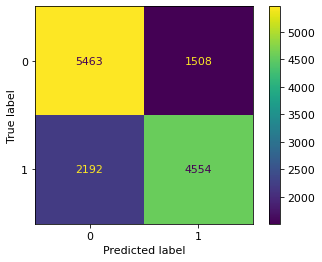

In [36]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Evaluation: Confusion matrix#
###############################
logreg_acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred) # Confusion matrix 
tpr_logreg = cm[1][1] /(cm[1][0] + cm[1][1])

print('The accuracy score is:', logreg_acc) # accuracy score
print('Sensitivity (TPR) =', tpr_logreg) 

print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_pred ))

plot_confusion_matrix(logreg, X_test, y_test)
plt.show()

### 1.2 - Feature Subset Selection <a class="anchor"  id="logreg2"></a>

In [37]:
# Sequential Forward Selection(sfs)
sfs = SequentialFeatureSelector(LogisticRegression(),
          direction='forward',
          scoring = 'accuracy',
          cv = 5,
          n_jobs=-1)

sfs.fit(X_train, y_train)
print("Features selected by forward sequential selection: " f"{sfs.get_feature_names_out()}")

Features selected by forward sequential selection: ['age' 'ap_hi' 'ap_lo' 'cholesterol' 'alco' 'active']


The accuracy score is: 0.7269811183203324
Sensitivity (TPR) = 0.6633560628520605

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6971
           1       0.75      0.66      0.71      6746

    accuracy                           0.73     13717
   macro avg       0.73      0.73      0.73     13717
weighted avg       0.73      0.73      0.73     13717



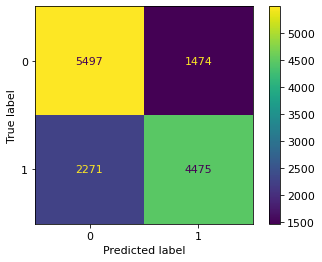

In [38]:
#train the model after subset selection with selected features
X_train_subset = X_train[sfs.get_feature_names_out()]
X_test_subset = X_test[sfs.get_feature_names_out()]

logreg_subset = LogisticRegression()
logreg_subset.fit(X_train_subset, y_train)
y_pred = logreg_subset.predict(X_test_subset)

# Evaluation: Confusion matrix#
###############################
logreg_acc_subset = accuracy_score(y_test, y_pred)
cm_subset = confusion_matrix(y_test, y_pred) # Confusion matrix 
tpr_logreg_subset = cm_subset[1][1] /(cm_subset[1][0] + cm_subset[1][1])

print('The accuracy score is:', logreg_acc_subset) # accuracy score
print('Sensitivity (TPR) =', tpr_logreg_subset)

print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_pred ))

plot_confusion_matrix(logreg_subset, X_test_subset, y_test)
plt.show()

### 1.3 - Tuned Logistic regression <a class="anchor"  id="logreg3"></a>

Using GridSearchCV can save quite a bit of effort in optimizing our machine learning model. It is computationally expensive.

The approach taken here allows us to find out the best hyperparameters for our dataset.

*  penalty — Specify the norm of the penalty.
*  C — Inverse of regularization strength; smaller values specify stronger regularization.

In [39]:
parameters = {
     'penalty' : ['l1','l2'],  #l1 lasso l2 ridge
     'C' : [0.001,0.01,0.1,1,10,100],
     }

tun_logreg = LogisticRegression()
clf_tun1 = GridSearchCV(tun_logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=5,                      # number of folds GridSearchCV does an internal 5-fold cross validation
                   verbose=3,
                   n_jobs=-1)                    

clf_tun1.fit(X_train,y_train)
print("Tuned Hyperparameters :", clf_tun1.best_params_)
print("Accuracy :",clf_tun1.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Tuned Hyperparameters : {'C': 100, 'penalty': 'l2'}
Accuracy : 0.72577324719251


- Here Logistic Regression model trained with default, forward subset selection and hyperparameter tuning gives us similar results,  so we choose the default model since it is significantly better.

## 2- Linear Discriminant analysis <a class="anchor"  id="lda"></a>

- LDA with default parameters

### 2.1 Basic Model

Accuracy = 0.7267624116060363
Sensitivity (TPR) = 0.6633560628520605

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      6971
           1       0.75      0.66      0.70      6746

    accuracy                           0.73     13717
   macro avg       0.73      0.73      0.73     13717
weighted avg       0.73      0.73      0.73     13717



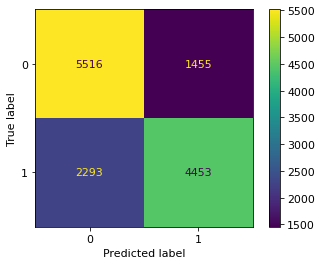

In [40]:
lda = LinearDiscriminantAnalysis(solver='lsqr', store_covariance=True)
lda.fit(X_train, y_train)
# Predict Test Set Responses #
##############################
y_predicted = lda.predict(X_test)
# convert the predicted probabilities to class 0 or 1
y_predicted= np.array(y_predicted > 0.5, dtype=float)

# Evaluation: Confusion matrix #
###############################
lda_acc = accuracy_score(y_test, y_predicted)  # accuracy score
cm_lda = confusion_matrix(y_test, y_pred) # Confusion matrix 
tpr_lda = cm_lda[1][1] /(cm_lda[1][0] + cm_lda[1][1])

print('Accuracy =', lda_acc)  
print('Sensitivity (TPR) =', tpr_lda)

print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_predicted ))

plot_confusion_matrix(lda, X_test, y_test)
plt.show()

## 3- Decision Tree <a class="anchor"  id="dt"></a>

- Default values of Decision Tree
- Tuned Decision Tree

### 3.1 - Basic Model

Accuracy: 0.6287818036013706
Sensitivity (TPR) = 0.6273347168692559

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.64      0.63      0.63      6971
           1       0.62      0.63      0.62      6746

    accuracy                           0.63     13717
   macro avg       0.63      0.63      0.63     13717
weighted avg       0.63      0.63      0.63     13717



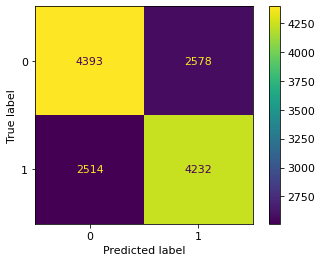

In [41]:
# min_samples_split: The minimum number of samples required to split an internal node
dtree = DecisionTreeClassifier()

# Build classification tree
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test)

# Evaluation: Confusion matrix #
################################
dtree_acc = accuracy_score(y_test, y_pred)   # accuracy score
cm_dtree = confusion_matrix(y_test, y_pred) # Confusion matrix 
tpr_dtree = cm_dtree[1][1] /(cm_dtree[1][0] + cm_dtree[1][1])

print("Accuracy:",dtree_acc)
print('Sensitivity (TPR) =', tpr_dtree)


print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_pred ))

plot_confusion_matrix(dtree, X_test, y_test)
plt.show()

### 3.2 - Tuned Decision Tree <a class="anchor"  id="dt1"></a>

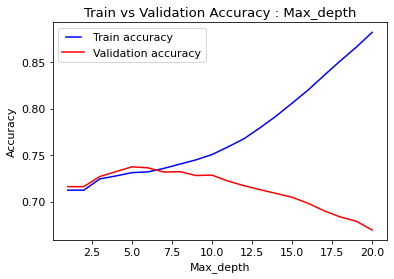

In [42]:
#Hyperparameter tuning for max_depth
train_acc1 = []
val_acc1 = []

for max_d in range(1,21):
  model = DecisionTreeClassifier(max_depth=max_d, random_state=42)
  model.fit(X_train, y_train)
  train_acc1.append(model.score(X_train, y_train))
  val_acc1.append(model.score(X_test,y_test))

line1, = plt.plot([*range(1,21)], train_acc1, 'b', label='Train accuracy')
line2, = plt.plot([*range(1,21)], val_acc1, 'r', label='Validation accuracy')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('Train vs Validation Accuracy : Max_depth')
plt.ylabel('Accuracy')
plt.xlabel('Max_depth')
plt.show()

train_acc1.clear()
val_acc1.clear()

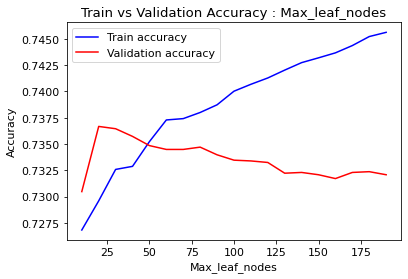

In [43]:
#Hyperparameter tuning for max_leaf_nodes
train_acc2 = []
val_acc2 = []

for max_ln in range(10,200,10):
  model2 = DecisionTreeClassifier(max_leaf_nodes=max_ln, random_state=42)
  model2.fit(X_train, y_train)
  train_acc2.append(model2.score(X_train, y_train))
  val_acc2.append(model2.score(X_test,y_test))


line3, = plt.plot([*range(10,200,10)], train_acc2, 'b', label='Train accuracy')
line4, = plt.plot([*range(10,200,10)], val_acc2, 'r', label='Validation accuracy')

plt.legend(handler_map={line2: HandlerLine2D(numpoints=2)})
plt.title('Train vs Validation Accuracy : Max_leaf_nodes')
plt.ylabel('Accuracy')
plt.xlabel('Max_leaf_nodes')
plt.show()

train_acc2.clear()
val_acc2.clear()

By carefully looking at the tuning results, we can see the max_depth=5 and max_leaf_nodes = 24 where the validation accuracy starts decreasing, and the training accuracy starts increasing.

Next, we will use the above parameters and re-train our model.

Accuracy: 0.7374061383684479
Sensitivity (TPR) = 0.681589089831011

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.72      0.79      0.75      6971
           1       0.76      0.68      0.72      6746

    accuracy                           0.74     13717
   macro avg       0.74      0.74      0.74     13717
weighted avg       0.74      0.74      0.74     13717



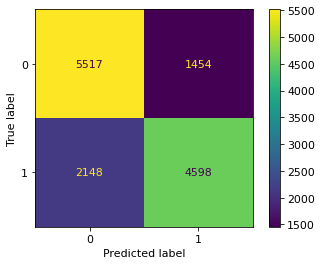

In [44]:
# min_samples_split: The minimum number of samples required to split an internal node
dtree_tuned = DecisionTreeClassifier(max_leaf_nodes=25,max_depth=5)

# Build classification tree
dtree_tuned.fit(X_train, y_train)

y_pred = dtree_tuned.predict(X_test)

# Evaluation: Confusion matrix #
################################
dtree_tuned_acc = accuracy_score(y_test, y_pred)   # accuracy score
cm_dtree_tuned = confusion_matrix(y_test, y_pred) # Confusion matrix 
tpr_dree_tuned = cm_dtree_tuned[1][1] /(cm_dtree_tuned[1][0] + cm_dtree_tuned[1][1])

print("Accuracy:",dtree_tuned_acc)  
print('Sensitivity (TPR) =', tpr_dree_tuned)

print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_pred ))

plot_confusion_matrix(dtree_tuned, X_test, y_test)
plt.show()

## 4 - Gradient Boosting *Classifier* <a class="anchor"  id="gbc"></a>

### 4.1 - Basic Model

Accuracy: 0.7369687249398557
Sensitivity (TPR) = 0.6958197450340943

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      6971
           1       0.75      0.70      0.72      6746

    accuracy                           0.74     13717
   macro avg       0.74      0.74      0.74     13717
weighted avg       0.74      0.74      0.74     13717



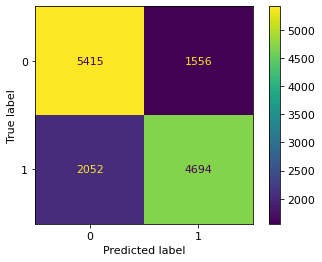

In [45]:
booster = GradientBoostingClassifier(max_depth=7,n_estimators=50,min_samples_split=1400,min_samples_leaf=60,max_features=7,subsample=0.85)
boost_est = booster.fit(X_train, y_train)

y_pred = boost_est.predict(X_test)

# Evaluation: Confusion matrix #
################################
boosting_acc = accuracy_score(y_test, y_pred) #accuracy score
cm_bossting = confusion_matrix(y_test, y_pred) # Confusion matrix 
tpr_boost = cm_bossting[1][1] /(cm_bossting[1][0] + cm_bossting[1][1]) #Sensitivity (TPR)

print('Accuracy:', boosting_acc) # accuracy score
print('Sensitivity (TPR) =', tpr_boost)

print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_pred ))

plot_confusion_matrix(boost_est, X_test, y_test)
plt.show()

In [46]:
#Additional one not yet finished you can try GradientBoosting 
# define the model
model = GradientBoostingClassifier()
# define the evaluation method
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model on the dataset
n_scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)
# report performance
print("%0.5f accuracy with a standard deviation of %0.2f" % (n_scores.mean(), n_scores.std()))

0.73377 accuracy with a standard deviation of 0.00


The Accuracy of the model is the average of the accuracy of each fold.



## 5 - K-Nearest Neighbors <a class="anchor"  id="knn"></a>

KNN is a widely used machine learning approach for classification tasks. An observation is classified by considering the K nearest neighbors and taking a majority vote.



### 5.1 Basic Model 

- Calculate some reference values for different values of K
- Using unscaled data 
- Similar weighting of all features 
  (unscaled data weights features in itself)  
- Considering every feature

Values for K:
 1, 5, 10, 20, 30, 40, 50

K-value that results in highest accuracy is used for further optimizing the model.

In [47]:
# Creating classifiers for every value of K
classifiers = []
nb_neighbor = [1, 5, 10, 20, 30, 40, 50]
for i in range(len(nb_neighbor)):
    classifiers.append(KNeighborsClassifier(nb_neighbor[i]))

# Initializing the lists for accuracy, true positive rate and true negative rate
# Later used to compare the classifiers for different values of K
score_list = []
true_positive = []
true_negative = []

# Fitting the training dataset for every classifier and calculating metrics

index = 0
for clf in classifiers: 
    clf.fit(X_train,y_train)

    score = clf.score(X_test, y_test)    
    y_pred = clf.predict(X_test)
    
    print(f"Accuracy for K =", nb_neighbor[index] ,"nearest Neighbors: ",  accuracy_score(y_test, y_pred))

    
    cm = confusion_matrix(y_test, y_pred) # Confusion matrix  

    score_list.append(score)
    true_positive.append(cm[1][1])
    true_negative.append(cm[0][0])
    
    index = index + 1




Accuracy for K = 1 nearest Neighbors:  0.6324998177444048
Accuracy for K = 5 nearest Neighbors:  0.686155864985055
Accuracy for K = 10 nearest Neighbors:  0.7071517095574834
Accuracy for K = 20 nearest Neighbors:  0.7149522490340453
Accuracy for K = 30 nearest Neighbors:  0.7191076766056718
Accuracy for K = 40 nearest Neighbors:  0.7224611795582124
Accuracy for K = 50 nearest Neighbors:  0.7234089086534956


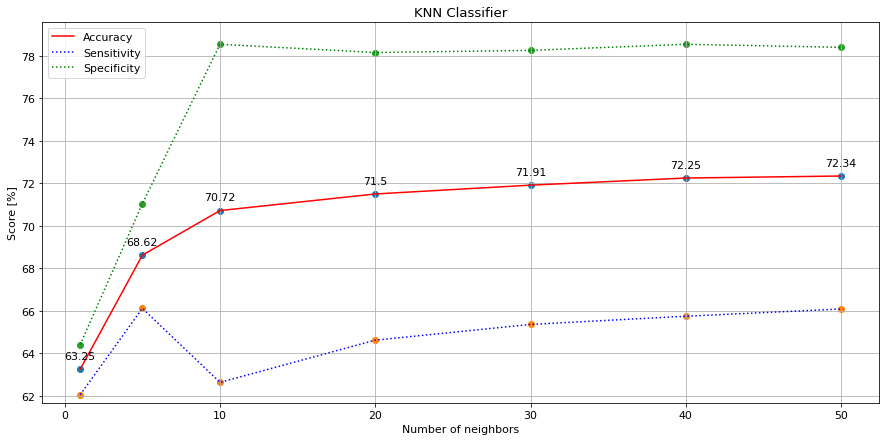

In [48]:
# Visualization of the results
plt.figure(figsize=(15, 7))
ax = ax
score_list = np.array(score_list)
score_list_plot = score_list * 100
true_positive_plot = np.array(true_positive)/sum(y_test) * 100
true_negative_plot = np.array(true_negative)/(len(y_test)-sum(y_test)) * 100
plt.plot(nb_neighbor, score_list_plot,  'r-')
plt.plot(nb_neighbor, true_positive_plot, 'b:')
plt.plot(nb_neighbor, true_negative_plot, 'g:')
plt.scatter(nb_neighbor, score_list_plot)
plt.scatter(nb_neighbor, true_positive_plot)
plt.scatter(nb_neighbor, true_negative_plot)
for x,y in zip(nb_neighbor,score_list_plot):

    label = "{:.2f}".format(y)

    plt.annotate(str(round(y, 2)), # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

plt.ylim(min(score_list_plot)* 0.975, max(score_list_plot)*1.1)
plt.xlabel('Number of neighbors')
plt.ylabel('Score [%]')
plt.title('KNN Classifier')
plt.legend(['Accuracy', 'Sensitivity', 'Specificity'])
plt.grid(True)
plt.show()


### 5.2 Feature Subset Selection <a class="anchor"  id="knn2"></a>

We will try to improve our model by performing a feature subset selection. We will use the currently best KNN classifier from the basic model.
Beforehand we performed forward and backward stepwise selection. Backward stepwise selection results in a higher accuracy and therefore used in this section.


In [49]:
# Find K with highest accuracy
max_score = max(score_list)
max_index = np.argmax(score_list)

max_nb_neighbor = nb_neighbor[max_index]


max_score_temp = max_score
opt_temp_classifier = KNeighborsClassifier(max_nb_neighbor)

print(f'The highest accuracy of:', round(max_score,4)*100, '% is achieved when considering', max_nb_neighbor, 'Neighbors')

The highest accuracy of: 72.34 % is achieved when considering 50 Neighbors


Since KNN performs a distance-based classification, we now use scaled data. For KNN, MinMax scaling has proven to be the best choice.

Furthermore, testing has shown that a specific overweighting of features based on the correlation with the target leads to an improvement of the KNN model.

In [50]:
# BACKWARD STEPWISE SELECTION
all_features = cardio_scaled_mm.columns
all_features = all_features.drop(['cardio'])

# weighting features based on the correlation with cardio
corr_list = cardio_scaled_mm.corrwith(cardio_scaled_mm['cardio'])
corr_list.drop(['cardio'], inplace = True)
for column in all_features:
    X_scaled_mm[column] = X_scaled_mm[column] * np.abs(corr_list[column])

label_column = 'cardio'
feature_columns = [c for c in cardio_cleaned.columns if c != label_column]

clf_KNN_BSS = KNeighborsClassifier(max_nb_neighbor)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)



In [51]:
def get_base_acc(y): # Calculating the base accuracy (using the median)
    predictions = [np.median(y)] * len(y)
    return accuracy_score(y, predictions)


def k_fold_acc(X, y, classifier, kfold): # Performing a k-fold cross validation (k=5)
    scores = cross_validate(classifier, X, y, scoring = 'accuracy', cv = kfold)
    return np.mean(scores['test_score']) 

In [52]:
def backward_stepwise_selection(X, y, classifier, kfold, all_features): # Performing backward stepwise selection
    current_acc = k_fold_acc(X, y, classifier, kfold)

    current_features = np.arange(len(feature_columns)) 
    
    best_acc = current_acc
    best_features = current_features[:]
    
    # as long as there is at least one feature used
    while len(current_features) > 0:

        non_selected_feature = None
        
        # checking whether leaving out a feature improves the accuracy
        for feature in current_features:

            new_features = np.delete(current_features, np.where(current_features == feature))
            
            acc = k_fold_acc(X[all_features[new_features]], y, classifier, kfold)
            
            # non_selected feature leads to highest increase in accuracy
            if acc > current_acc:
                non_selected_feature = feature
                current_acc = acc
        
        # Deleting non_selected feature, if there is one that improves the accuracy when being left out
        if non_selected_feature is not None:

            current_features = np.delete(current_features, np.where(current_features == non_selected_feature))
        else:
            # Otherwise terminate and leave while-loop
            break
    
    # returning the features that are still in the model
    if current_acc > get_base_acc(y):

        return current_features, current_acc
    else:
      
        return [], get_base_acc(y)
    

In [53]:
# Calling the backward stepwise selection function
features, accuracy = backward_stepwise_selection(X_scaled_mm, y_scaled_mm, clf_KNN_BSS, kfold, all_features)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 1/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ...............C=0.001, penalty=l2;, score=0.722 total time=   0.7s
[CV 5/5] END ...............C=0.001, penalty=l2;, score=0.722 total time=   0.5s
[CV 1/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END .................C=0.1, penalty=l2;, score=0.729 total time=   0.6s
[CV 4/5] END .................C=0.1, penalty=l2;, score=0.724 total time=   0.7s
[CV 5/5] END .................C=0.1, penalty=l2;, score=0.725 total time=   0.6s
[CV 2/5] END ...............

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 2/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ...............C=0.001, penalty=l2;, score=0.729 total time=   0.6s
[CV 1/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ................C=0.01, penalty=l2;, score=0.719 total time=   0.7s
[CV 3/5] END ................C=0.01, penalty=l2;, score=0.729 total time=   0.6s
[CV 1/5] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ...................C=1, penalty=l2;, score=0.729 total time=   0.6s
[CV 1/5] END ...............

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV 4/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ...............C=0.001, penalty=l2;, score=0.728 total time=   0.6s
[CV 5/5] END ..................C=0.01, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END ................C=0.01, penalty=l2;, score=0.729 total time=   0.7s
[CV 2/5] END .................C=0.1, penalty=l2;, score=0.721 total time=   0.7s
[CV 3/5] END .................C=0.1, penalty=l2;, score=0.729 total time=   0.7s
[CV 4/5] END ...................C=1, penalty=l2;, score=0.724 total time=   0.7s
[CV 5/5] END ...................C=1, penalty=l2;, score=0.724 total time=   0.6s
[CV 2/5] END .................C=100, penalty=l2;, score=0.721 total time=   0.6s
[CV 5/5] END .................C=100, penalty=l2;, score=0.724 total time=   0.4s


In [54]:
all_features = cardio_cleaned.columns
all_features = all_features.drop(['cardio'])
print("Selected features:")
for idx in sorted(features):
    print(f"\t{all_features[idx]}")

print("Features left out:")
for idx in (set(range(len(feature_columns))) - set(features)):
    print(f"\t{all_features[idx]}")
    
print(f"Accuracy of the selected model: {accuracy:.3f}")




Selected features:
	age
	gender
	height
	weight
	ap_hi
	ap_lo
	cholesterol
	gluc
	smoke
	active
	BMI
Features left out:
	alco
Accuracy of the selected model: 0.732


### 5.3 Hyperparameter Tuning <a class="anchor"  id="knn3"></a>
- Finding the optimal value for K (just a subset of values that we tried beforehand, "optimal" value is in the subset)
- Only using the features that are still in the model after performing backward stepwise selection


Accuracy for K = 1 nearest Neighbors:  0.6424145221258293
Accuracy for K = 10 nearest Neighbors:  0.7140045199387621
Accuracy for K = 25 nearest Neighbors:  0.7311365458919589
Accuracy for K = 50 nearest Neighbors:  0.7325216884158343
Accuracy for K = 100 nearest Neighbors:  0.7349274622730918
Accuracy for K = 150 nearest Neighbors:  0.7355106801778815
Accuracy for K = 200 nearest Neighbors:  0.7349274622730918
Accuracy for K = 250 nearest Neighbors:  0.7351461689873879
Accuracy for K = 300 nearest Neighbors:  0.7368229204636583
Accuracy for K = 350 nearest Neighbors:  0.736385507035066
Accuracy for K = 400 nearest Neighbors:  0.7363126047969673
Accuracy for K = 450 nearest Neighbors:  0.7361668003207699
Accuracy for K = 500 nearest Neighbors:  0.7374061383684479


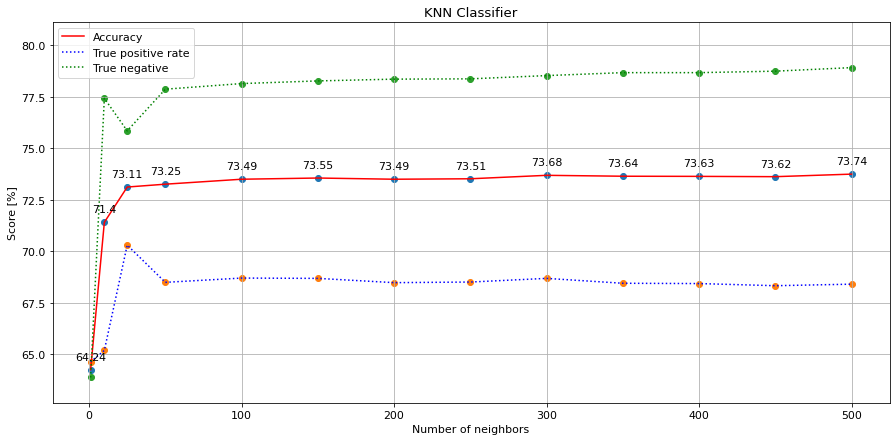

In [55]:
# For each classifier declare the parameters
classifiers = []
nb_neighbor = [1, 10, 25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
for i in range(len(nb_neighbor)):
    classifiers.append(KNeighborsClassifier(n_neighbors = nb_neighbor[i]))


# Only using the selected features
cardio_selected = cardio_cleaned.copy()
features_selected = [feature_columns[feature_i] for feature_i in range(len(feature_columns)) if feature_i in features]

X_KNN = X_scaled_mm[features_selected]
y_KNN = y_scaled_mm

X_KNN_train, X_KNN_test, y_KNN_train, y_KNN_test = train_test_split(X_KNN, y_KNN, test_size=0.2, random_state=42, shuffle = True)

accuracy_KNN = []
true_positive_KNN = []
true_negative_KNN = []

index = 0
for clf in classifiers: 
    clf.fit(X_KNN_train,y_KNN_train)

    score = clf.score(X_KNN_test, y_KNN_test)    
    y_KNN_pred = clf.predict(X_KNN_test)
    
    print(f"Accuracy for K =", nb_neighbor[index] ,"nearest Neighbors: ",  accuracy_score(y_KNN_test, y_KNN_pred))

    
    cm = confusion_matrix(y_KNN_test, y_KNN_pred) # Confusion matrix  

    accuracy_KNN.append(score)
    true_positive_KNN.append(cm[1][1])
    true_negative_KNN.append(cm[0][0])
    
    index = index + 1


# Again plotting the metrics for every classifier
plt.figure(figsize=(15, 7))
ax = ax
accuracy_KNN = np.array(accuracy_KNN)
score_list_plot = accuracy_KNN * 100
true_positive_plot = np.array(true_positive_KNN)/sum(y_test) * 100
true_negative_plot = np.array(true_negative_KNN)/(len(y_test)-sum(y_test)) * 100
plt.plot(nb_neighbor, score_list_plot,  'r-')
plt.plot(nb_neighbor, true_positive_plot, 'b:')
plt.plot(nb_neighbor, true_negative_plot, 'g:')
plt.scatter(nb_neighbor, score_list_plot)
plt.scatter(nb_neighbor, true_positive_plot)
plt.scatter(nb_neighbor, true_negative_plot)
for x,y in zip(nb_neighbor,score_list_plot):

    label = "{:.2f}".format(y)

    plt.annotate(str(round(y, 2)), # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')

plt.ylim(min(score_list_plot)* 0.975, max(score_list_plot)*1.1)
plt.xlabel('Number of neighbors')
plt.ylabel('Score [%]')
plt.title('KNN Classifier')
plt.legend(['Accuracy', 'True positive rate', 'True negative'])
plt.grid(True)
plt.show()



Accuracy = 0.7374061383684479
True positive rate = 0.6839608656981915

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.72      0.79      0.75      6971
           1       0.76      0.68      0.72      6746

    accuracy                           0.74     13717
   macro avg       0.74      0.74      0.74     13717
weighted avg       0.74      0.74      0.74     13717



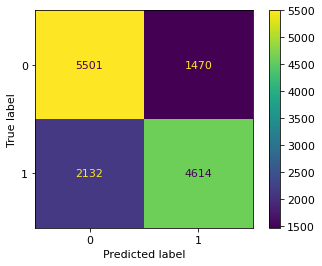

In [56]:
# Final Evaluation of KNN with "optimal" Classifier and subset of features
max_score = max(accuracy_KNN)
max_index = np.argmax(accuracy_KNN)

n_neighbor_opt = nb_neighbor[max_index]

opt_classifier_KNN = KNeighborsClassifier(n_neighbor_opt)
best_model = opt_classifier_KNN.fit(X_KNN_train,y_KNN_train)
y_KNN_pred = opt_classifier_KNN.predict(X_KNN_test)

 
cm_KNN = confusion_matrix(y_KNN_test, y_KNN_pred) # Confusion matrix  
true_positive_KNN = cm_KNN[1][1]/sum(y_test)
accuracy_KNN = accuracy_score(y_KNN_test, y_KNN_pred)
print('Accuracy =', accuracy_KNN)  
print('True positive rate =', cm_KNN[1][1]/sum(y_test))  

print('\n Confusion matrix \n \n')
print(classification_report(y_KNN_test, y_KNN_pred))

plot_confusion_matrix(opt_classifier_KNN, X_KNN_test, y_KNN_test)
plt.show()


## 6 - Quadratic Discriminant Analysis <a class="anchor"  id="qda"></a>

### 6.1 - No Subset Selection <a class="anchor"  id="qda1"></a>

Accuracy = 0.6991324633666254
Sensitivity (TPR) = 0.5887933590275719

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.67      0.81      0.73      6971
           1       0.75      0.59      0.66      6746

    accuracy                           0.70     13717
   macro avg       0.71      0.70      0.69     13717
weighted avg       0.71      0.70      0.70     13717



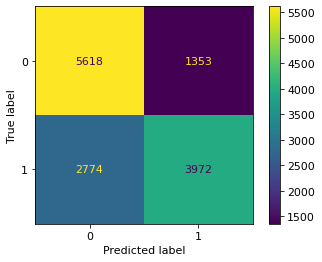

In [57]:
#define and fit classifier
qdaClassifier = QuadraticDiscriminantAnalysis(store_covariance=True)
qdaClassifier.fit(X_train,y_train)
#get predictions
y_predict = qdaClassifier.predict(X_test)
y_predicted= np.array(y_predict > 0.5, dtype=float)
#get evaluation criteria
qda_acc = accuracy_score(y_test, y_predicted) 
qda_cm = confusion_matrix(y_test, y_predicted)
qda_tpr = qda_cm[1][1] /(qda_cm[1][0] + qda_cm[1][1])
print('Accuracy =', qda_acc)
print('Sensitivity (TPR) =', qda_tpr)

print('\n Confusion matrix \n \n')
print(classification_report(y_test, y_predicted ))

plot_confusion_matrix(qdaClassifier, X_test, y_test)
plt.show()

### 6.2 - With Forward Subset Selection <a class="anchor"  id="qda2"></a>

Tested with forward and backward subset selection. Forward performs slightly better but difference is minimal. Scaling of dataset has no effect.

In [58]:
resFSS = {}
for i in range(1,len(X_train.columns)):
    #define and fit classifier for different feature selections
    qdaClassifierFSS = SequentialFeatureSelector(QuadraticDiscriminantAnalysis(store_covariance=True),n_features_to_select=i, direction='forward')
    qdaClassifierFSS.fit(X_train,y_train)
    redu = qdaClassifierFSS.get_support()

    clms = []
    for idx,val in enumerate(X_train.columns):
        if redu[idx]:
            clms.append(val)

    X_trainFSS = pd.DataFrame(qdaClassifierFSS.transform(X_train),columns=clms)
    X_testFSS = pd.DataFrame(qdaClassifierFSS.transform(X_test),columns=clms)

    qdaClassifierFSS = QuadraticDiscriminantAnalysis(store_covariance=True)
    qdaClassifierFSS.fit(X_trainFSS,y_train)
    #get predictions
    y_predict = qdaClassifierFSS.predict(X_testFSS)
    y_predicted= np.array(y_predict > 0.5, dtype=float)
    #get evaluation criteria
    qdaFSS_acc = accuracy_score(y_test, y_predicted)
    qdaFSS_cm = confusion_matrix(y_test, y_predicted)
    qdaFSS_tpr = qda_cm[1][1] /(qda_cm[1][0] + qda_cm[1][1])
    qdaFSS_report = classification_report(y_test, y_predicted)
    resFSS[str(clms)] = ([qdaFSS_acc, qdaFSS_report, qdaClassifierFSS, X_testFSS, y_test, qdaFSS_tpr])

Selected subset includes some expected parameters like age, ap_hi and cholesterol. It also includes values with low correlation to cardio like height.

In [59]:
#get selected subset
scores = []
for i in range(len(resFSS.values())):
    scores.append(list(resFSS.values())[i][0])
bestRes = max(scores)
idx = scores.index(bestRes)

selected_subset = list(resFSS.keys())[idx]
qdaFSS_results = list(resFSS.values())[idx]

print(selected_subset)

['age', 'gender', 'height', 'ap_hi', 'cholesterol', 'active']


Accuracy = 0.7199096012247576
Sensitivity (TPR) = 0.5887933590275719

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.69      0.83      0.75      6971
           1       0.77      0.61      0.68      6746

    accuracy                           0.72     13717
   macro avg       0.73      0.72      0.72     13717
weighted avg       0.73      0.72      0.72     13717



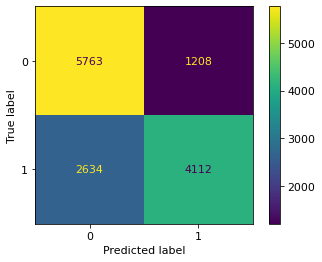

In [60]:
print('Accuracy =', qdaFSS_results[0])  
print('Sensitivity (TPR) =', qdaFSS_results[5])

print('\n Confusion matrix \n \n')
print(qdaFSS_results[1])

plot_confusion_matrix(qdaFSS_results[2], qdaFSS_results[3], qdaFSS_results[4])
plt.show()

## 7 - Random Forest <a class="anchor"  id="rf"></a>

Scaling has no effect on Random Forest Classifier since it doesn't affect tree splits. 

Feature Selection happens randomly and automatically and could have been used to improve convergence rate at the cost of potentially worse outcome.

Hyperparameter tuning was done with cross validation. Number of trees produced stable results at around 300 trees and was ultimately chosen at 500 as tradeoff between consistency and runtime. 

More tests (for tree size, hyperparameters) were performed than currently in the code but were cut due to runtime constraints and code readability.

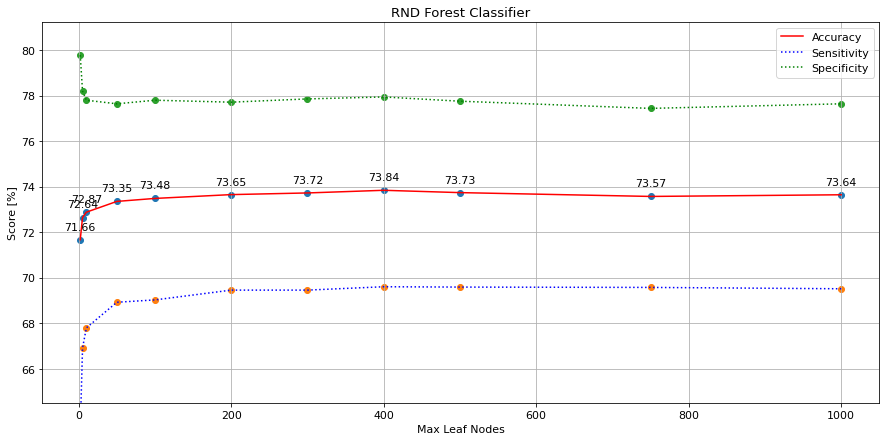

In [61]:
viewer_mode = True
rndF_classifiers = []
if viewer_mode:
  n_ests = [2,5,10,50,100,200,300,400,500,750,1000]
  for n_est in n_ests: # add append to dict like knn
    rndF_classifiers.append(RandomForestClassifier(n_estimators=500, max_depth=20, max_features='sqrt', max_leaf_nodes=n_est))

  acc_list = []
  tpr_list = []
  report_list = []
  true_positive = []
  true_negative = []

  for clf in rndF_classifiers: 
    clf.fit(X_train,y_train)

    y_predict = clf.predict(X_test)
    y_predicted = np.array(y_predict > 0.5, dtype=float)

    rndForest_acc = accuracy_score(y_test, y_predicted)
    cm = confusion_matrix(y_test, y_predicted)
    rndForest_tpr = cm[1][1] /(cm[1][0] + cm[1][1])
    rndForest_report = classification_report(y_test, y_predicted)

    acc_list.append(rndForest_acc)
    tpr_list.append(rndForest_tpr)
    report_list.append(rndForest_report)
    true_positive.append(cm[1][1])
    true_negative.append(cm[0][0])

  plt.figure(figsize=(15, 7))
  ax = ax
  score_list = np.array(acc_list)
  score_list_plot = score_list * 100
  true_positive_plot = np.array(true_positive)/sum(y_test) * 100
  true_negative_plot = np.array(true_negative)/(len(y_test)-sum(y_test)) * 100
  plt.plot(n_ests, score_list_plot,  'r-')
  plt.plot(n_ests, true_positive_plot, 'b:')
  plt.plot(n_ests, true_negative_plot, 'g:')
  plt.scatter(n_ests, score_list_plot)
  plt.scatter(n_ests, true_positive_plot)
  plt.scatter(n_ests, true_negative_plot)
  for x,y in zip(n_ests,score_list_plot):

      label = "{:.2f}".format(y)

      plt.annotate(str(round(y, 2)), # this is the text
                  (x,y), # these are the coordinates to position the label
                  textcoords="offset points", # how to position the text
                  xytext=(0,10), # distance from text to points (x,y)
                  ha='center')

  plt.ylim(min(score_list_plot)* 0.9, max(score_list_plot)*1.1)
  plt.xlabel('Max Leaf Nodes')
  plt.ylabel('Score [%]')
  plt.title('RND Forest Classifier')
  plt.legend(['Accuracy', 'Sensitivity', 'Specificity'])
  plt.grid(True)
  plt.show()

    

else:
  rndForestClassifier = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [500], 'max_features':['sqrt'], 'max_depth':[20], 'max_leaf_nodes':[500, 1000, 1500]}, cv=5, scoring=['accuracy','recall'], refit='accuracy').fit(X_train, y_train)
  print(rndForestClassifier.best_estimator_)
  param_selection = rndForestClassifier.cv_results_['params']
  test_scores = rndForestClassifier.cv_results_['mean_test_score']
  for i in param_selection:
    print(i)
  print(test_scores)
  

Number of leaf nodes is the most impactful parameter for the quality of the fit. The comparison between a subset of values shows a maximum at 300 leaf nodes for the test set accuracy.

Leaf Nodes = 400
Accuracy = 0.7383538674637311
Sensitivity (TPR) = 0.695967981025793

 Confusion matrix 
 

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      6971
           1       0.75      0.70      0.72      6746

    accuracy                           0.74     13717
   macro avg       0.74      0.74      0.74     13717
weighted avg       0.74      0.74      0.74     13717



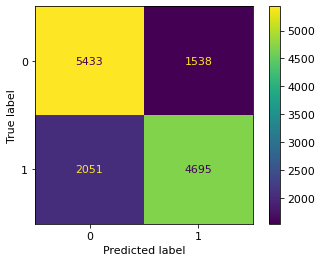

In [62]:
if viewer_mode:
  rndForest_acc = max(acc_list)
  max_index = np.argmax(acc_list)
  max_nest = n_ests[max_index]
  rndForest_tpr = tpr_list[max_index]
  rndForest_report = report_list[max_index]
  rndForestClassifier = rndF_classifiers[max_index]

  print('Leaf Nodes =', max_nest)
  print('Accuracy =', rndForest_acc)
  print('Sensitivity (TPR) =', rndForest_tpr)
  
  print('\n Confusion matrix \n \n')
  print(rndForest_report)

  plot_confusion_matrix(rndForestClassifier, X_test, y_test)
  plt.show()
else:
  y_predict = rndForestClassifier.predict(X_test)
  y_predicted = np.array(y_predict > 0.5, dtype=float)

  rndForest_acc = accuracy_score(y_test, y_predicted)
  rndForest_report = classification_report(y_test, y_predicted)
  rndForest_cm = confusion_matrix(y_test, y_predicted)
  rndForest_tpr = rndForest_cm[1][1] /(rndForest_cm[1][0] + rndForest_cm[1][1])

  print('Accuracy =', rndForest_acc)
  print('Sensitivity (TPR) =', rndForest_tpr)
  
  print('\n Confusion matrix \n \n')
  print(rndForest_report)

  plot_confusion_matrix(rndForestClassifier, X_test, y_test)
  plt.show()

## 8 - Support Vector Classifier <a class="anchor"  id="svc"></a>

- Comparison of differet kernels (Linear, Radial Basis Function and Polynomial with a degree of 3)
- Feature Subset Selection and Hyperparameter Tuning does not improve the accuracy (tested beforehand and left out due to time constraint)


In [63]:
viewer_mode = True
if viewer_mode:
  print("Support Vector Classifier takes very long.")
else:
  C = 1.0  # SVM regularization parameter
  models = (svm.SVC(kernel='linear', C=C),
            svm.SVC(kernel='rbf', gamma=0.7, C=C),
            svm.SVC(kernel='poly', degree=3, gamma='auto', C=C))


  accuracy_svc = []
  for clf in models: 
      clf.fit(X_train_scaled, y_train_scaled)
      y_pred = clf.predict(X_test_scaled)
      accuracy_svc.append(accuracy_score(y_test_scaled, y_pred))
      print(f"Accuracy: ",  accuracy_score(y_test_scaled, y_pred))


Support Vector Classifier takes very long.


In [64]:
if viewer_mode:
  max_accuracy_svc=0.734126
  true_positive_svc=0.660243 	
  print('Support Vector Classifier with highest accuracy: Polynomial')
  print('Accuracy =', max_accuracy_svc) 
  print('Sensitivity (TPR) =', true_positive_svc)
else:
  svc_clf_list = ['Linear', 'Radial Basis Function', 'Polynomial']

  max_accuracy_svc = max(accuracy_svc)
  max_svc_index = np.argmax(accuracy_svc)

  svc_clf = models[max_svc_index]
  svc_clf.fit(X_train_scaled, y_train_scaled)
  y_predict = svc_clf.predict(X_test_scaled)
  svc_report = classification_report(y_test, y_predict)

  cm_svc = confusion_matrix(y_test, y_predict)

  true_positive_svc = cm_svc[1][1]/sum(y_test)

  print('Accuracy =', max_accuracy_svc) 
  print('Sensitivity (TPR) =', true_positive_svc)
  print('Support Vector Classifier with highest accuracy:', svc_clf_list[max_svc_index]) 

  print('\n Confusion matrix \n \n')
  plot_confusion_matrix(svc_clf, X_test_scaled, y_test_scaled)
  plt.show()

Support Vector Classifier with highest accuracy: Polynomial
Accuracy = 0.734126
Sensitivity (TPR) = 0.660243


# Conclusion <a class="anchor"  id="conc"></a>

The different classifiers still need to be compared in their prediction quality. The group chose to look at both accuracy and sensitivity (true positive Rate).
Accuracy because predictions should be correct as often as possible. Sensitivity because not predicting disease is more dangerous for person's life than not predicting health.

The weight of sensitivity was chosen at 0.25 because it was intended to give an "all positive classifier" a considerably worse score than a classifier of around 3/4 accuracy.
\begin{equation}
objective\ value = accuracy + sensitivity \cdot 0.25
\end{equation}


In [65]:
#collect results
tpr_weight = 0.25
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Linear Discriminant analysis', 'Decision Tree', 
              'GradientBoostingClassifier', ' Nearest Neighbor', 'QDA', 'Random Forest', 'Support Vector Classifier'],
    'Accuracy': [logreg_acc, lda_acc, dtree_tuned_acc, boosting_acc, accuracy_KNN, qdaFSS_results[0], rndForest_acc, max_accuracy_svc],
                    
    'Sensitivity' : [tpr_logreg,tpr_lda,tpr_dree_tuned,tpr_boost,true_positive_KNN, qdaFSS_results[5], rndForest_tpr, true_positive_svc],
    'Objective Value' : [logreg_acc + tpr_logreg*tpr_weight, lda_acc+tpr_lda*tpr_weight, dtree_tuned_acc+tpr_dree_tuned*tpr_weight,
                         boosting_acc+tpr_boost*tpr_weight, accuracy_KNN+true_positive_KNN*tpr_weight, 
                         qdaFSS_results[0]+qdaFSS_results[5]*tpr_weight, rndForest_acc+rndForest_tpr*tpr_weight,
                         max_accuracy_svc+true_positive_svc*tpr_weight] })

models

,Model,Accuracy,Sensitivity,Objective Value
0,Logistic Regression,0.730262,0.675067,0.899028
1,Linear Discriminant analysis,0.726762,0.663356,0.892601
2,Decision Tree,0.737406,0.681589,0.907803
3,GradientBoostingClassifier,0.736969,0.695820,0.910924
4,Nearest Neighbor,0.737406,0.683961,0.908396
5,QDA,0.719910,0.588793,0.867108
6,Random Forest,0.738354,0.695968,0.912346
7,Support Vector Classifier,0.734126,0.660243,0.899187


As can be seen in the table above, all classifiers lie between 70% and 75% for accuracy and perform worse for sensitivity. The polynomial classifiers Decision Tree, Gradient Boosting Classifier, Nearest Neighbor and Random Forest performed slightly better in both regards than other classifiers.

In [66]:
#collect results for plotting
df_plotting = pd.DataFrame({
    'Model': ['Logistic Regression', 'Linear Discriminant analysis', 'Decision Tree', 
              'GradientBoostingClassifier', ' Nearest Neighbor', 'QDA', 'Random Forest', 'Support Vector Classifier', 
              'Logistic Regression', 'Linear Discriminant analysis', 'Decision Tree', 
              'GradientBoostingClassifier', ' Nearest Neighbor', 'QDA', 'Random Forest', 'Support Vector Classifier'],
    'Values': [logreg_acc, lda_acc, dtree_tuned_acc, boosting_acc, accuracy_KNN, qdaFSS_results[0], rndForest_acc, max_accuracy_svc,
             tpr_logreg,tpr_lda,tpr_dree_tuned,tpr_boost,true_positive_KNN, qdaFSS_results[5], rndForest_tpr, true_positive_svc],
    'Type': ['Accuracy', 'Accuracy','Accuracy','Accuracy','Accuracy','Accuracy','Accuracy','Accuracy', 
             'Sensitivity', 'Sensitivity', 'Sensitivity', 'Sensitivity', 'Sensitivity', 'Sensitivity', 'Sensitivity', 'Sensitivity']})

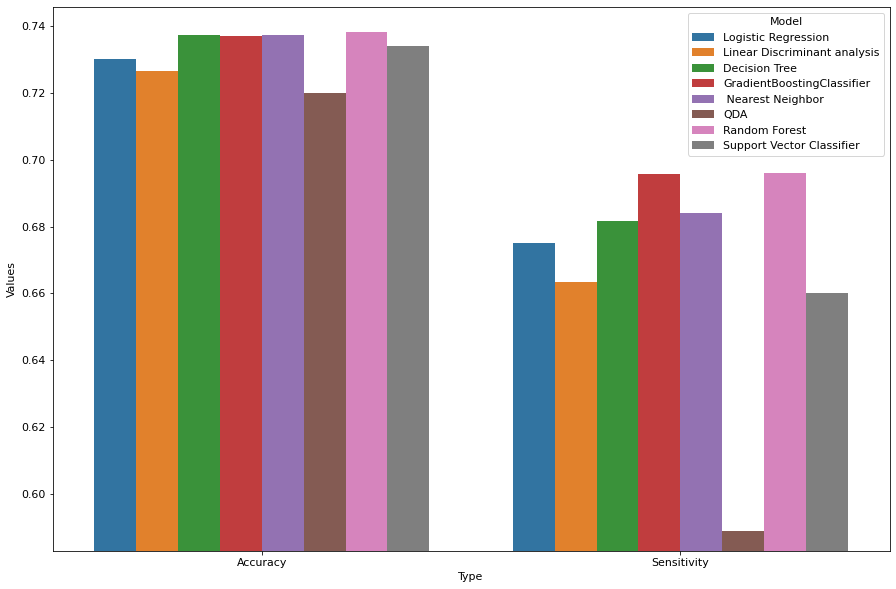

In [67]:
#plot result comparison
plt.figure(figsize=(15,10))
sns.barplot(y=df_plotting['Values'],x=df_plotting['Type'], hue=df_plotting['Model'], orient ="v")
plt.ylim(min(df_plotting['Values'])* 0.99, max(df_plotting['Values'])*1.01)
#plt.gcf().set_size_inches(50,10)
plt.show()

The variance between the classifiers is higher in regard to sensitivity than to accuracy. All classifiers were worse at classifying sick people than healthy people. This difference is most pronounced in QDA and SVM.

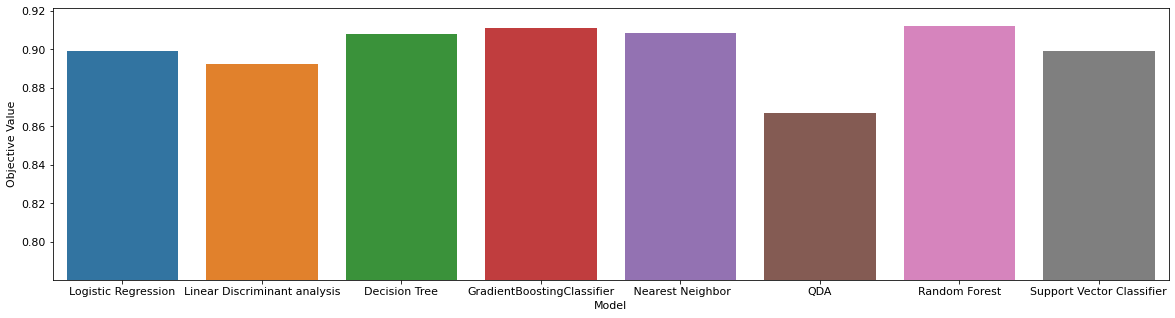

In [68]:
#plot result comparison
plt.figure(figsize=(20,5))
sns.barplot(y=models['Objective Value'],x=models['Model'], orient ="v")
#sns.barplot(y=models['Sensitivity'],x=models['Model'], orient ="v")
plt.ylim(min(models['Objective Value'])* 0.9, max(models['Objective Value'])*1.01)
#sns.despine()
plt.show()

The difference in objective value between the better classifiers, Decision Tree, Gradient Boosting Classifier, Nearest Neighbor and Random Forest is only marginal. These difference could very well be explained by the train/test split or the decisions taken in the data cleaning process and can not be clearly attributed to the superiority of one classifier. 